In [4]:
!pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

  Preparing metadata (setup.py) ... done
  Created wheel for tf-nightly-gpu-2.0-preview: filename=tf_nightly_gpu_2_0_preview-0.0.0.1-py3-none-any.whl size=1542 sha256=454834d10c7acaa3fddac403fb087abff2a89ee534015d36c1237844d35de842
  Stored in directory: /root/.cache/pip/wheels/89/c6/2e/5b35865ca6234c39a564b7803e8105a8050cb66121a475b27c
Successfully built tf-nightly-gpu-2.0-preview


In [5]:
device_name=tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **Xception model**

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
# Ensure TensorFlow is using GPU

if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available and being used.")
else:
    print("❌ No GPU found. Check Kaggle settings.")

✅ GPU is available and being used.


Class Distribution Before Oversampling:
DRUSEN: 8616 images
CNV: 37205 images
NORMAL: 51140 images
DME: 11348 images


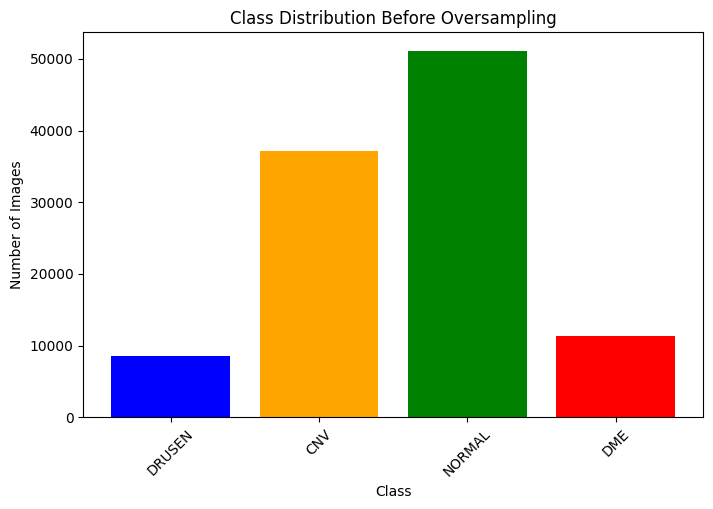

In [8]:
# -------------------------------
# Count Images in Each Class (Before Training)
# -------------------------------
import os 

def count_images_in_classes(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):  
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

dataset_path = "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/train"
class_counts_before = count_images_in_classes(dataset_path)

print("Class Distribution Before Oversampling:")
for class_name, count in class_counts_before.items():
    print(f"{class_name}: {count} images")

# Plot class distribution before oversampling
plt.figure(figsize=(8, 5))
plt.bar(class_counts_before.keys(), class_counts_before.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution Before Oversampling")
plt.xticks(rotation=45)
plt.show()

In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load the training set (76,000 images)
training_set = image_dataset_from_directory(
    "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/train",  # Use the original dataset folder
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=42,
    validation_split=1 - (76000 / 108309),  # The remaining images will go to validation
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

# Load the validation set (remaining images)
validation_set = image_dataset_from_directory(
    "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/train",  # Same dataset directory
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=42,
    validation_split=1 - (76000 / 108309),  # Same split ratio
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

print("Train dataset size:", training_set.cardinality().numpy() * 32)
print("Validation dataset size:", validation_set.cardinality().numpy() * 32)


Found 108309 files belonging to 4 classes.
Using 76000 files for training.
Found 108309 files belonging to 4 classes.
Using 32309 files for validation.
Train dataset size: 76000
Validation dataset size: 32320


In [12]:
INPUT_SHAPE=(224,224,3)

In [13]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

resNet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

resNet.trainable = False 

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# Add custom classification layers
x = GlobalAveragePooling2D()(resNet.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(4, activation="softmax")(x)  # 4 classes (CNV, DME, DRUSEN, NORMAL)

In [15]:
# Create final model
model = Model(inputs=resNet.input, outputs=x)

In [16]:
metrics_list=["accuracy", tf.keras.metrics.F1Score()]

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=metrics_list)

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 24,615,940 (93.90 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [19]:
training_history=model.fit(x=training_set, validation_data=validation_set, epochs=15)

Epoch 1/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 321s 129ms/step - accuracy: 0.5186 - f1_score: 0.3380 - loss: 7.0367 - val_accuracy: 0.6678 - val_f1_score: 0.3764 - val_loss: 0.8960
Epoch 2/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 227s 95ms/step - accuracy: 0.6452 - f1_score: 0.3786 - loss: 0.9457 - val_accuracy: 0.7076 - val_f1_score: 0.4069 - val_loss: 0.7950
Epoch 3/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 227s 96ms/step - accuracy: 0.6863 - f1_score: 0.4222 - loss: 0.8562 - val_accuracy: 0.7265 - val_f1_score: 0.4721 - val_loss: 0.7486
Epoch 4/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 227s 96ms/step - accuracy: 0.7064 - f1_score: 0.4511 - loss: 0.8100 - val_accuracy: 0.7350 - val_f1_score: 0.4538 - val_loss: 0.7203
Epoch 5/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 227s 96ms/step - accuracy: 0.7183 - f1_score: 0.4657 - loss: 0.7818 - val_accuracy: 0.7434 - val_f1_score: 0.4980 - val_loss: 0.7135
Epoch 6/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 227s 96ms/step - accuracy: 0.7252 - f1_score: 0.4790 - loss: 0.7605 - val_accuracy

In [20]:
model.save("resNet_model.h5")
model.save("resNet_model.keras")

In [21]:
import pickle

# Save the training history (history.history is a dict with loss/accuracy values per epoch)
with open("resNet_Training_history.pkl", "wb") as file:
    pickle.dump(training_history.history, file)

In [22]:
# Unfreeze last 30 layers for fine-tuning
for layer in resNet.layers[-30:]:
    layer.trainable = True

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=metrics_list)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)

In [28]:
# Train with data augmentation and fine-tuning
history_fine_tune = model.fit(x=training_set, validation_data=validation_set, epochs=10,callbacks=[early_stopping, reduce_lr])

Epoch 1/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 327s 131ms/step - accuracy: 0.6755 - f1_score: 0.4995 - loss: 0.8708 - val_accuracy: 0.8183 - val_f1_score: 0.6055 - val_loss: 0.5255 - learning_rate: 1.0000e-05
Epoch 2/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 307s 129ms/step - accuracy: 0.8501 - f1_score: 0.6783 - loss: 0.4440 - val_accuracy: 0.8726 - val_f1_score: 0.7526 - val_loss: 0.3708 - learning_rate: 1.0000e-05
Epoch 3/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 306s 129ms/step - accuracy: 0.8842 - f1_score: 0.7810 - loss: 0.3424 - val_accuracy: 0.8956 - val_f1_score: 0.8063 - val_loss: 0.3115 - learning_rate: 1.0000e-05
Epoch 4/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 306s 129ms/step - accuracy: 0.9028 - f1_score: 0.8215 - loss: 0.2899 - val_accuracy: 0.9088 - val_f1_score: 0.8322 - val_loss: 0.2742 - learning_rate: 1.0000e-05
Epoch 5/10
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 307s 129ms/step - accuracy: 0.9160 - f1_score: 0.8465 - loss: 0.2498 - val_accuracy: 0.9117 - val_f1_score: 0.8438 - val_loss: 0.2647 - learni

In [29]:
model.save("resNet_model_fine_tune.h5")
model.save("resNet_model_fine_tune.keras")

In [30]:
import pickle

# Save the training history (history.history is a dict with loss/accuracy values per epoch)
with open("resNet_Training_history_fine_tune.pkl", "wb") as file:
    pickle.dump(history_fine_tune.history, file)

# **Model performance**

In [31]:
#REloading history from pickle file
import pickle
with open("resNet_Training_history_fine_tune.pkl", "rb") as f:
    load_history=pickle.load(f)
print(load_history)

{'accuracy': [0.7611842155456543, 0.8613289594650269, 0.890500009059906, 0.9069605469703674, 0.9204210638999939, 0.9307894706726074, 0.9414079189300537, 0.9503815770149231, 0.9582894444465637, 0.964802622795105], 'f1_score': [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.829595  , 0.3607472 , 0.02412627, 0.84178567], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.90758413, 0.6831281 , 0.33242112, 0.9217865 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9265825 , 0.76143414, 0.5454901 , 0.93847436], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9370093 , 0.80606616, 0.62299955, 0.9479166 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.94645846, 0.83615375, 0.6759123 , 0.9561392 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9523972 , 0.863431  , 0.718535  , 0.96216345], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.96070963, 0.

In [32]:
load_history.keys()

dict_keys(['accuracy', 'f1_score', 'loss', 'val_accuracy', 'val_f1_score', 'val_loss', 'learning_rate'])

ValueError: x and y must have same first dimension, but have shapes (15,) and (10,)

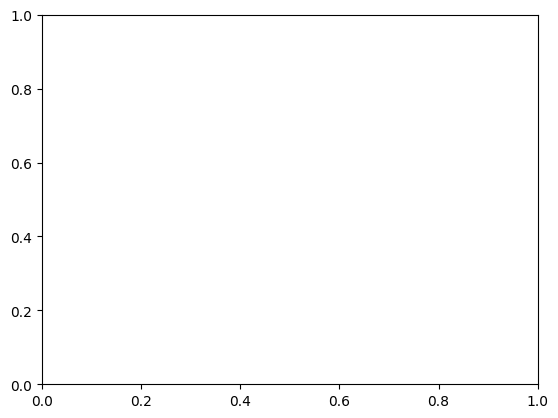

In [33]:
#Loss visualization
epochs=[i for i in range(1, 16)]
plt.plot(epochs, load_history['loss'], color='red', label='Training loss')
plt.plot(epochs, load_history['val_loss'], color='Blue', label='Validation loss')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of loss result")
plt.legend()
plt.show()

# **Model Evaluation**

In [53]:
#pre-processing the test dataset
test_set = image_dataset_from_directory(
    "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/test",  # Same dataset directory
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1000 files belonging to 4 classes.


In [54]:
test_loss, test_acc, f1_score=model.evaluate(test_set)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8954 - f1_score: 0.5493 - loss: 0.3016


In [55]:
test_loss, test_acc, f1_score

(0.5191541910171509,
 0.8240000009536743,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.884058  , 0.93177384, 0.5558739 , 0.83276445], dtype=float32)>)

In [56]:
true_categories=tf.concat([y for x, y in test_set], axis=0)
Y_true=tf.argmax(true_categories, axis=1)

In [57]:
#computing predicted labels using test_set
predicted_categories = model.predict(test_set)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


In [58]:
Y_Pred=tf.argmax(predicted_categories, axis=1)
Y_Pred

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
    

# **Classification Report**

In [59]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_Pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.88       250
           1       0.91      0.96      0.93       250
           2       0.98      0.39      0.56       250
           3       0.73      0.98      0.83       250

    accuracy                           0.82      1000
   macro avg       0.86      0.82      0.80      1000
weighted avg       0.86      0.82      0.80      1000



# **Confusion Matrix**

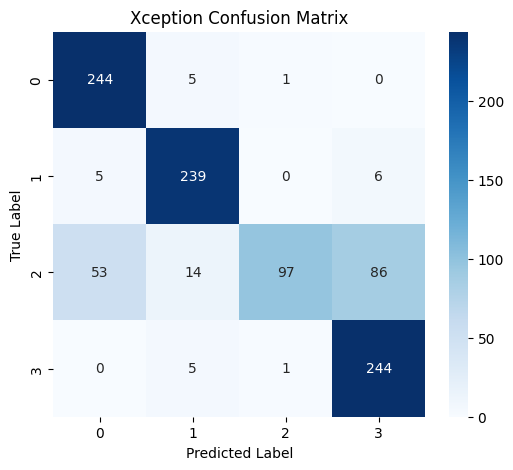

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm=confusion_matrix(Y_true, Y_Pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Xception Confusion Matrix", fontsize=12)
plt.show()

# **Single Prediction Code**

In [61]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import numpy as np
import os

In [ ]:
model = tf.keras.models.load_model("MobileNet_model.h5")

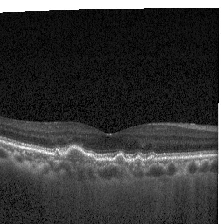

In [66]:
image_path = "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/test/DRUSEN/DRUSEN-11129-2.jpeg"
img = tf.keras.utils.load_img(image_path, target_size=(224,224))
img

In [67]:
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [68]:
x.shape

(1, 224, 224, 3)

In [69]:
pred = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [70]:
class_name=['CNV', 'DME', 'DRUSEN', 'NORMAL']
result_index = np.argmax(pred)
print("Model Prediction: ", class_name[result_index])

Model Prediction:  CNV
